In [18]:
from netCDF4 import Dataset

import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout, wx_code_to_numeric
from metpy.io import metar

import pandas as pd

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [19]:
hr = "23"

fileName = "20221227_" + hr + "00"

nc = Dataset(fileName)

In [20]:
#read in variables needed for plotting surface station plots
station_name = nc.variables['stationName'][:]
latitude = nc.variables['latitude'][:]
longitude = nc.variables['longitude'][:]
temp = (nc.variables['temperature'][:]-273.15)*(9/5)+32.0
dwpt = (nc.variables['dewpoint'][:]-273.15)*(9/5)+32.0
wspd = nc.variables['windSpeed'][:]
wdir = nc.variables['windDir'][:]
gust = nc.variables['windGust'][:]
weather = nc.variables['presWeather'][:]
visibility = nc.variables['visibility'][:]
pslp = nc.variables['seaLevelPress'][:]/100 #pascal to hPa
skycover = nc.variables['skyCover'][:]

print(station_name[0])
print(weather[0])
print(skycover[0])

[b'N' b'Z' b'S' b'P' --]
[b'S' b'G' b' ' b'B' b'R' -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- --]
[[b'F' b'E' b'W' -- -- -- -- --]
 [b'O' b'V' b'C' -- -- -- -- --]
 [-- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- --]
 [-- -- -- -- -- -- -- --]]


/home/samuel.t.halvorson/miniconda3/envs/atsc270/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [21]:
#convert station names from masked byte array to list of strings
stn_names = ['']*len(station_name)
for index in range(len(station_name)):
    stn = station_name[index].tobytes().decode().rstrip('\x00')
    stn_names[index] = stn

#convert present weather from masked byte array to list of strings
cur_wx = ['']*len(weather)
for index in range(len(weather)):
    wx = weather[index].tobytes().decode().rstrip('\x00')
    cur_wx[index] = wx

#converting the current weather string to numerical value for metpy plotting
wx_codes = wx_code_to_numeric(cur_wx)

sky_cover_num = np.empty(len(skycover),dtype=int)
for i in range(len(skycover)):
    this_skycvr = skycover[i].tobytes().decode().rstrip('\x00')

    #SCTSCTBKNBKNBKN
    #BKNBKNOVC
    #CLR

    
    if this_skycvr[-3:] == 'SKC' or this_skycvr[-3:] == 'CLR':
        sky_cover_num[i] = 0
    elif this_skycvr[-3:] == 'FEW':
        sky_cover_num[i] = 2
    elif this_skycvr[-3:] == 'SCT':
        sky_cover_num[i] = 4
    elif this_skycvr[-3:] == 'BKN':
        sky_cover_num[i] = 6
    elif this_skycvr[-3:] == 'OVC':
        sky_cover_num[i] = 8
    else:
        sky_cover_num[i] = 10

print(sky_cover_num)

[ 8  0  0 ... 10  8  8]


In [22]:
#get u and v wind components
wspd_from_nc = np.array(wspd)*units('m/s')
wdir_from_nc = np.array(wdir)*units('degrees')
u,v = mpcalc.wind_components(wspd_from_nc,wdir_from_nc)

/tmp/ipykernel_2782921/4042983410.py:4: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  u,v = mpcalc.wind_components(wspd_from_nc,wdir_from_nc)


In [23]:
#convert our data to a pandas dataframe
data_for_df = {'station_id':stn_names,
               'latitude':latitude,
               'longitude':longitude,
               'wind_direction':wdir,
               'wind_speed':wspd,
               'wind_gust':gust,
               'visibility':visibility,
               'current_wx1_symbol':wx_codes,
               'air_temperature':temp,
               'dew_point_temperature':dwpt,
               'air_pressure_at_sea_level':pslp,
               'eastward_wind':u,
               'northward_wind':v,
               'cloud_coverage': sky_cover_num}

#col_names = ['station_id','latitude','longitude','wind_direction','wind_speed','wind_gust',
#             'visibility','current_wx1_symbol','air_temperature','dew_point_temperature','air_pressure_at_sea_level']

data = pd.DataFrame(data_for_df,index=stn_names)
print(data)

     station_id   latitude   longitude  wind_direction  wind_speed  wind_gust  \
NZSP       NZSP -90.000000  180.000000           330.0         5.1        NaN   
NZCM       NZCM -77.870003  166.970001            70.0         8.2       11.8   
NZCM       NZCM -77.870003  166.970001            70.0         9.8       12.9   
NZCM       NZCM -77.870003  166.970001            70.0         9.3       12.9   
NZWD       NZWD -77.870003  167.080002            80.0         8.2        NaN   
...         ...        ...         ...             ...         ...        ...   
CYGL       CYGL  53.630001  -77.699997           220.0         3.6        NaN   
KW99       KW99  38.970001  -79.129997             0.0         0.0        NaN   
CWUK       CWUK  49.820000  -74.980003           180.0         1.0        NaN   
KNY0       KNY0  42.980000  -74.330002           280.0         1.5        NaN   
KDOV       KDOV  39.130001  -75.470001           110.0         1.5        NaN   

      visibility  current_w

In [24]:
#map projection jusing a Lambert Conformaeastl Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)





#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)

#now thin the data
data_thinned = data[mpcalc.reduce_point_density(locs,150*units('km'))]

/home/samuel.t.halvorson/miniconda3/envs/atsc270/lib/python3.11/site-packages/cartopy/crs.py:479: RuntimeWarning: overflow encountered in square
  vector_magnitudes = (u**2 + v**2)**0.5


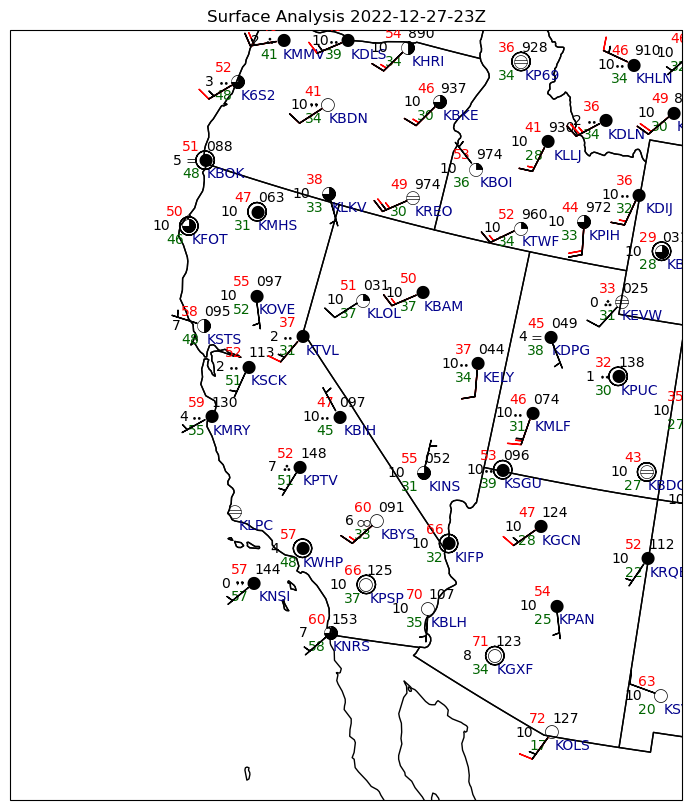

In [25]:
#create wind gust vectors
#get wind direction from metpy
u = data_thinned.eastward_wind.values * units('knots')
v = data_thinned.northward_wind.values * units('knots')
gust = data_thinned.wind_gust.values * units('knots')
#print(u)
wdir = mpcalc.wind_direction(u,v)
#get wind gust components assuming same direction using metpy wind components
ug,vg = mpcalc.wind_components(gust,wdir)

#map projection
proj = ccrs.LambertConformal(central_longitude=-95,central_latitude=35)

#create figure
fig = plt.figure(figsize=(10,10),dpi=100)
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

#zoom on the
ax.set_extent((-125, -110, 30, 45))


#create stationplot (will actually need to create 2 to handle wind gusts)
stationplots = StationPlot(ax,data_thinned['longitude'],data_thinned['latitude'],transform=ccrs.PlateCarree(),clip_on=True,fontsize=10)
stationplots_gusts = StationPlot(ax,data_thinned['longitude'],data_thinned['latitude'],transform=ccrs.PlateCarree(),clip_on=True,fontsize=10)


#temperature in red
stationplots.plot_parameter((-1,1), data_thinned['air_temperature'].values, color='red')
#dewpoint in dark green
stationplots.plot_parameter((-1,-1), data_thinned['dew_point_temperature'].values, color='darkgreen')

#pressure (need to format to be the final 3 digits)
stationplots.plot_parameter((1,1), data_thinned['air_pressure_at_sea_level'].values, color='black',
                               formatter=lambda p: format(10*p, '.0f')[-3:])

#station ID in dark blue
stationplots.plot_text((1.5,-1), data_thinned['station_id'].values, color='darkblue')

#visibility in black (need to convert from meters to miles)
stationplots.plot_parameter((-2,0),data_thinned['visibility'].values*units('meters').to(units('miles')),color='black')

#wind gust in red
stationplots_gusts.plot_barb(ug,vg,color='red',zorder=9)

#wind in black
stationplots.plot_barb(u,v,color='black',zorder=10)

#cloud cover
stationplots.plot_symbol((0,0), data_thinned['cloud_coverage'].values, sky_cover)

#current weather
stationplots.plot_symbol((-1,0), data_thinned['current_wx1_symbol'].values, current_weather)

#save the map as surface_obs.png

plt.title("Surface Analysis 2022-12-27-" + hr + "Z")
plt.savefig(fileName)